In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import probplot
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
# Check for missing values
data.isnull().sum().sum()

0

No Missing value

## 1. Exploratory Data Analysis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
data[['Time','Amount','Class']].describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16
Class,284807.0,0.001727,0.041527,0.0,0.0,0.0,0.000,1.00


<AxesSubplot:ylabel='Class'>

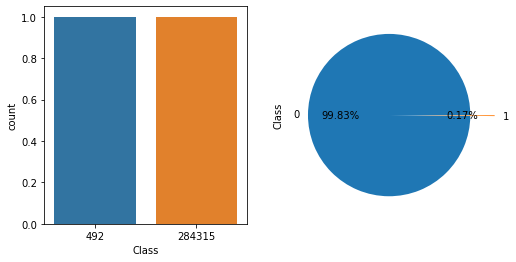

In [8]:
# Class Distribution
plt.rcParams['figure.figsize'] = (8, 4)
plt.subplot(121)
sns.countplot(data['Class'].value_counts())

plt.subplot(122)
data['Class'].value_counts().plot(kind = 'pie', explode = [0, 0.3 ],  autopct='%1.2f%%')

The dataset is highly imbalanced, Positive class (frauds) account 0.17% of all transactions

Text(0.5, 1.0, 'Class == Normal')

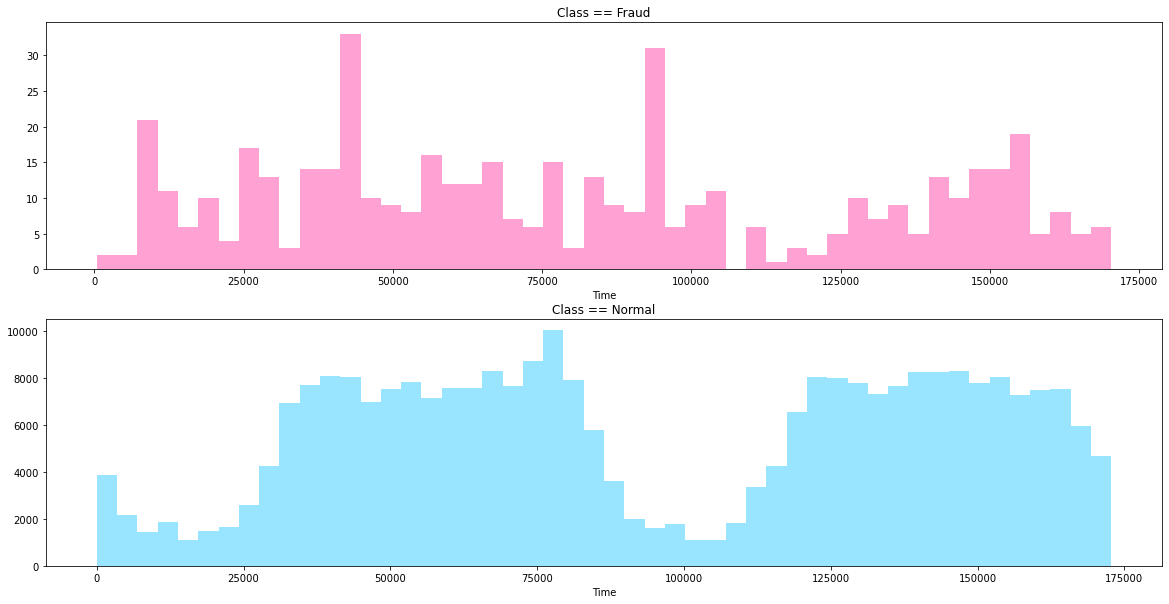

In [9]:
# Time distribution
plt.rcParams['figure.figsize'] = (20,10)

plt.subplot(211)
sns.distplot(data[data['Class'] == 1]['Time'], kde = False, color = 'deeppink', bins = 50)
plt.title('Class == Fraud')
plt.subplot(212)
sns.distplot(data[data['Class'] == 0]['Time'], kde = False, color = 'deepskyblue', bins = 50)
plt.title('Class == Normal')

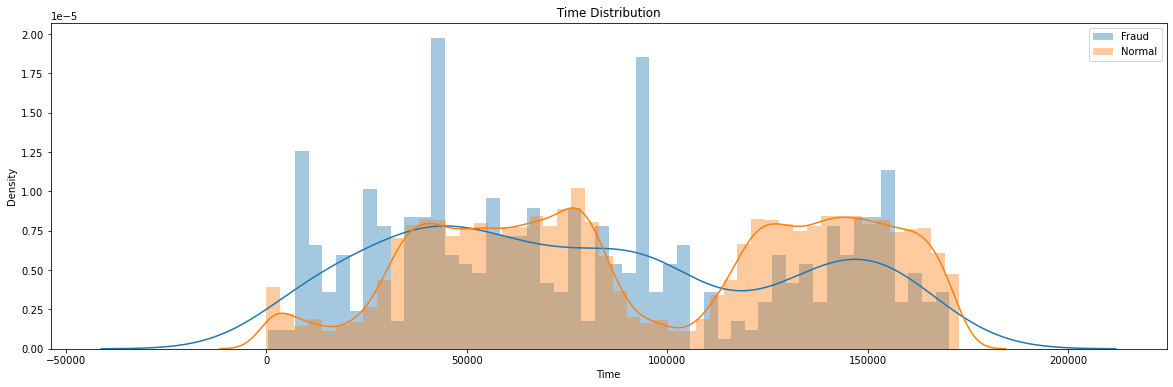

In [10]:
# Time distribution
plt.rcParams['figure.figsize'] = (20,6)

sns.distplot(data[data['Class'] == 1]['Time'], bins = 50, label = 'Fraud')
sns.distplot(data[data['Class'] == 0]['Time'], bins = 50, label = 'Normal')
plt.title(' Time Distribution ')
plt.legend()


<AxesSubplot:xlabel='Time', ylabel='Amount'>

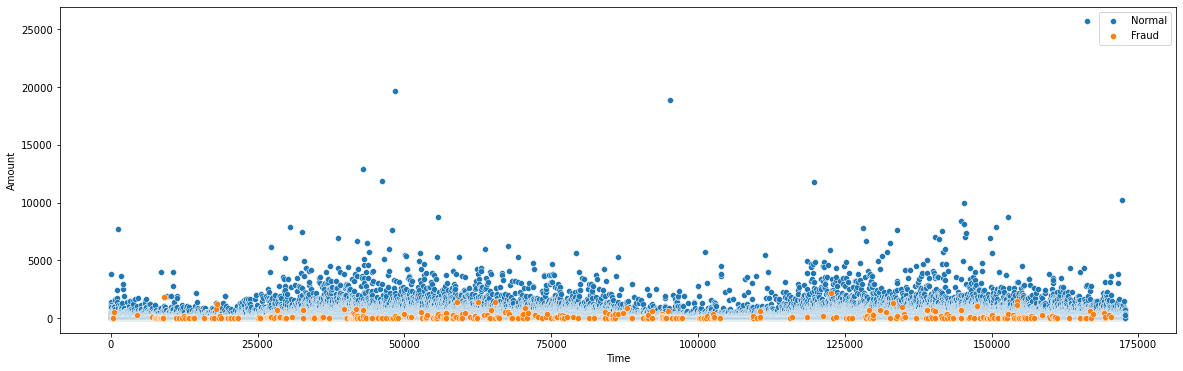

In [11]:
# Amount Distribution 

sns.scatterplot(y = data[data['Class'] == 0]['Amount'], x = data[data['Class'] == 0]['Time'], label = 'Normal' )
sns.scatterplot(y = data[data['Class'] == 1]['Amount'], x = data[data['Class'] == 1]['Time'], label = 'Fraud' )


Transaction Amount in Fradulent are generally lower compared to Normal Transaction. Normal transactions have highest values

(0.0, 300.0)

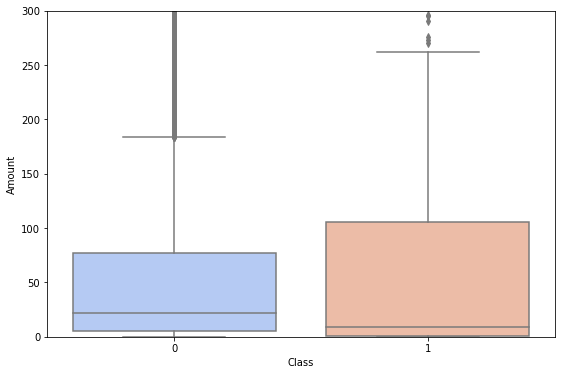

In [12]:
# Boxplot Amount Vs Class
plt.subplot(121)
ax = sns.boxplot(x = data['Class'], y = data['Amount'], palette = 'coolwarm')
ax.set_ylim([0, 300])

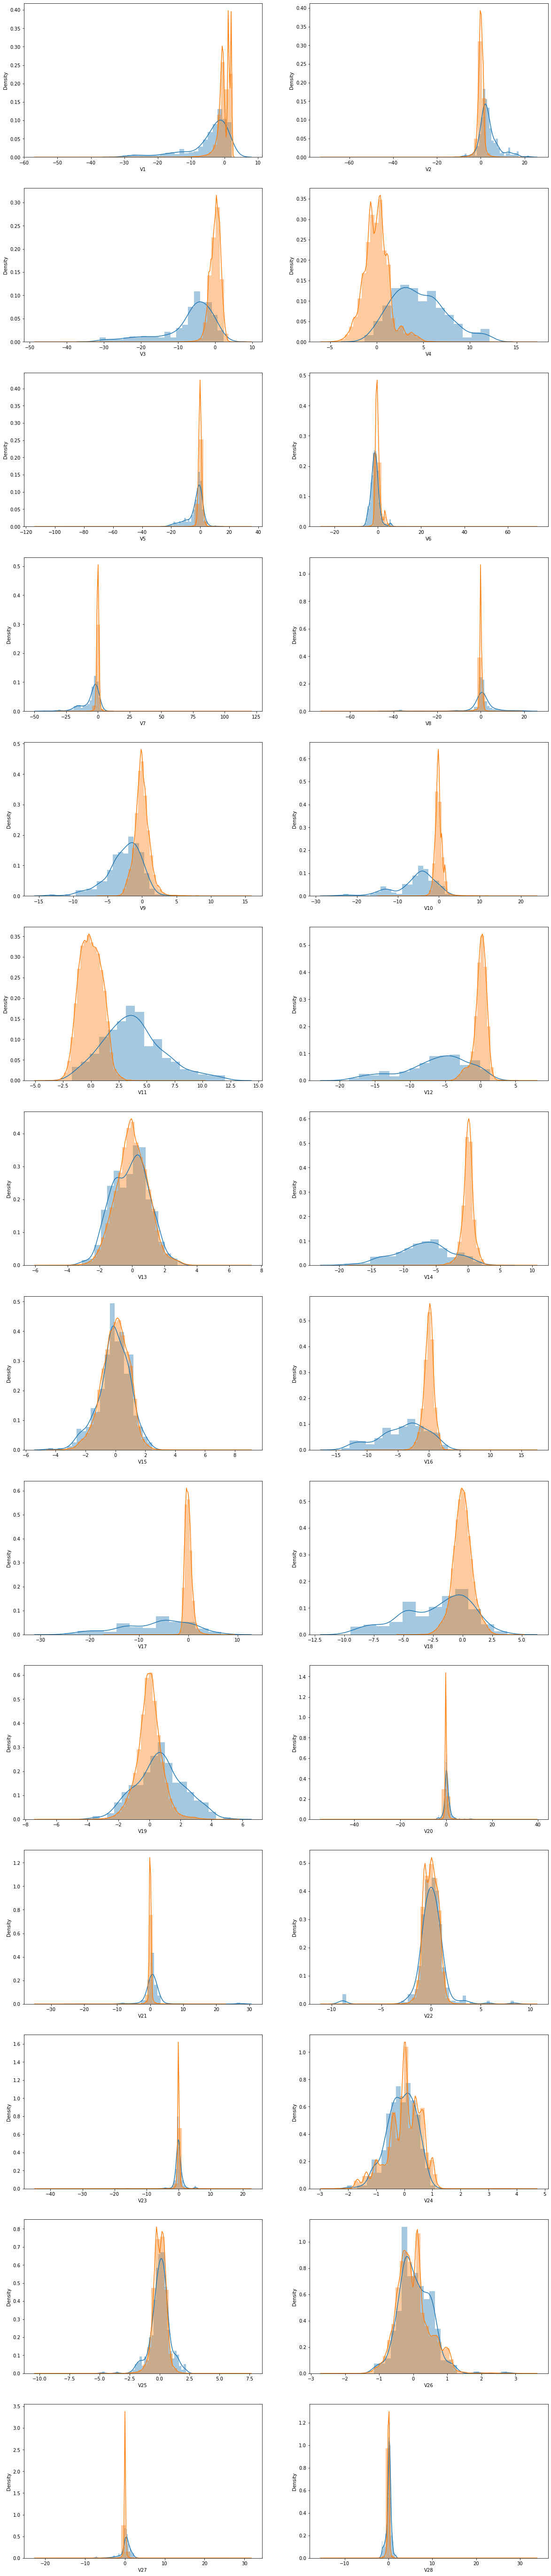

In [13]:
# Distribution of Feature V1 to V28 
plt.rcParams['figure.figsize'] = (20,100)
fig, ax = plt.subplots(14,2)
feature_index = 1
for row in range(14):
    for col in range(2):
        if(feature_index < 29):
            sns.distplot(data[data['Class'] == 1]['V' + str(feature_index)], ax = ax[row][col])
            sns.distplot(data[data['Class'] == 0]['V' + str(feature_index)], ax = ax[row][col])
            feature_index = feature_index + 1

We can see a interesting different distribuition in some of our features like V4, V9, V16, V17 and a lot more.

## 2. Feature Engineering

((array([-4.57041983, -4.38097388, -4.27824463, ...,  4.27824463,
          4.38097388,  4.57041983]),
  array([    0.  ,     0.  ,     0.  , ..., 18910.  , 19656.53, 25691.16])),
 (139.24730982213092, 88.34961925093131, 0.5567134536311757))

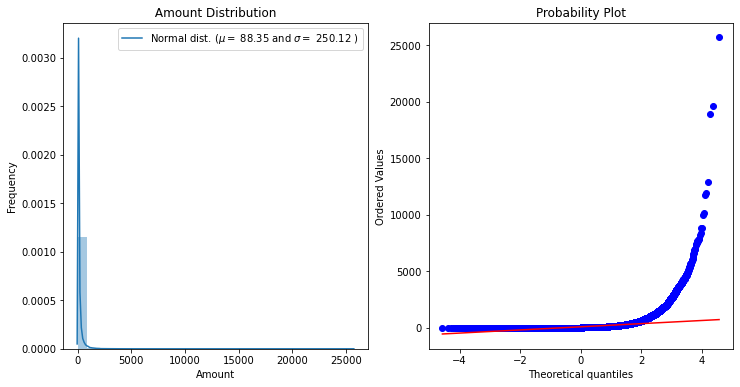

In [14]:
plt.rcParams['figure.figsize'] = (12,6)
plt.subplot(121)
(mu, sigma) = norm.fit(data['Amount'])
sns.distplot(data['Amount'], kde = True, bins = 30)
plt.ylabel('Frequency')
plt.title(' Amount Distribution ')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

plt.subplot(122)
probplot(data['Amount'],plot = plt)

In [15]:
# Transformation for Amount 
data['Amount'] = np.log(data['Amount'] + 0.01)

((array([-4.57041983, -4.38097388, -4.27824463, ...,  4.27824463,
          4.38097388,  4.57041983]),
  array([-4.60517019, -4.60517019, -4.60517019, ...,  9.84744669,
          9.88616539, 10.15390263])),
 (1.9269032975345237, 2.9603637358546533, 0.9877427806298623))

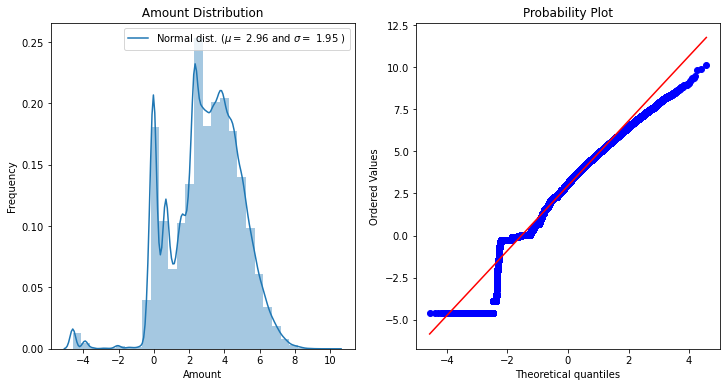

In [16]:
plt.rcParams['figure.figsize'] = (12,6)
plt.subplot(121)
(mu, sigma) = norm.fit(data['Amount'])
sns.distplot(data['Amount'], kde = True, bins = 30)
plt.ylabel('Frequency')
plt.title(' Amount Distribution ')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

plt.subplot(122)
probplot(data['Amount'],plot = plt)

In [17]:
# Drop unused features
data.drop(['Time'], axis = 1, inplace = True)

In [18]:
# Independent & Dependent variable

X = np.array(data.drop(['Class'], axis = 'columns'))
y = np.array(data['Class'].tolist())

In [19]:
# Train & Test split - Stratified K-folds

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

## 3. Model Metrics building

In [20]:
# 1. Precision, Recall, F1-Score

def show_metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Precision : {:.3f}'.format(precision))
    print('Recall : {:.3f}'.format(recall))
    print('f1 : {:.3f}'.format(f1))
    return precision, recall, f1

In [21]:
# 2. Confusion Matrix
def plot_confusion_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.rcParams['figure.figsize'] = (4,4)
    sns.heatmap(cm, annot = True, fmt = 'd')

In [22]:
# 3. ROC Curve
def plot_roc_curve(y_test, y_pred):
    plt.rcParams['figure.figsize'] = (6,4)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr,label = 'ROC Curve', linewidth = 2)
    plt.plot([0,1], [0,1], 'k--', linewidth = 2)
    plt.title(' ROC Curve')
    return fpr, tpr, threshold

In [23]:
# 4. Precision / Recall Curve
def plot_precision_recall_curve(y_test, y_pred):
    plt.rcParams['figure.figsize'] = (6,4)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, linewidth = 2)
    plt.fill_between(recall, precision, alpha = 0.2, color = 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')

In [24]:
feature_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount']

In [25]:
# 5. Feature Importance Plot
def feature_importance_plot(feature_importances, features):
    df_features = pd.DataFrame({'Feature': features, 'Feature Importance' : feature_importances})
    df_features.sort_values(by = 'Feature Importance', ascending = False, inplace = True)
    plt.rcParams['figure.figsize'] = (20,10)
    sns.barplot(x = 'Feature Importance', y = 'Feature', data = df_features)

## 4. Model Training

###  1. Logistic Regression

In [26]:
# Logistic Regression 
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)
show_metrics(y_test, lr_pred)

Precision : 0.870
Recall : 0.684
f1 : 0.766


(0.8701298701298701, 0.6836734693877551, 0.7657142857142857)

In [27]:
# Grid Search CV for optimising 

params = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.1, 1, 10, 100]
            }
cv = GridSearchCV(estimator = lr_model, param_grid = params, scoring = 'recall', verbose = 1, n_jobs = -1)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.3s finished


{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}


In [31]:
# Logistic Regression with best hyper parameters
lr_model = LogisticRegression(C = 1, class_weight = 'balanced', penalty= 'l2')
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)
precision_lr, recall_lr, f1_lr = show_metrics(y_test, y_pred)

Precision : 0.062
Recall : 0.878
f1 : 0.116


### 2. Random Forest Classification

In [32]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
show_metrics(y_test, rf_predict)

Precision : 0.926
Recall : 0.765
f1 : 0.838


(0.9259259259259259, 0.7653061224489796, 0.8379888268156425)

In [ ]:
# # Hyper parameter tunning
# params = {
#             'n_estimators': [100, 200, 500],
#             'max_features': [2, 3],
#             'min_samples_leaf': [1, 2, 4],
#             'min_samples_split': [2, 5, 10]
#             }
# cv = GridSearchCV(estimator = rf_model, param_grid = params, scoring = 'f1', verbose = 10, n_jobs = -1)
# cv.fit(X_train, y_train)
# print(cv.best_params_)

In [33]:
# Best Hyperparameters

rf_model = RandomForestClassifier(max_features = 3, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 500)
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
precision_rf, recall_rf, f1_rf = show_metrics(y_test, rf_predict)


Precision : 0.927
Recall : 0.776
f1 : 0.844


### 3. Extreme Gradient Boosting (XGB)

In [34]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predict = xgb_model.predict(X_test)
show_metrics(y_test, xgb_predict)

Precision : 0.895
Recall : 0.786
f1 : 0.837


(0.8953488372093024, 0.7857142857142857, 0.8369565217391304)

In [35]:
# Hyper parameter tunning XG Boost
params = {'n_estimators' : [100, 200, 300, 400, 500]}
cv = GridSearchCV(estimator = xgb_model, param_grid = params, scoring = 'f1', verbose = 2)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=  22.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s


[CV] ................................. n_estimators=100, total=  24.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  24.3s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  24.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  24.4s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  49.6s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  49.1s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  49.5s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 30.7min finished


{'n_estimators': 500}


In [36]:
# XG Boost with best hyper parameter
xgb_model = XGBClassifier( n_estimators = 500)
xgb_model.fit(X_train, y_train)
xgb_predict = xgb_model.predict(X_test)
precision_xgb, recall_xgb, f1_xgb = show_metrics(y_test, xgb_predict)

Precision : 0.918
Recall : 0.796
f1 : 0.852


#### More changes for future improvement to model
    * Threshold testing
    * Voting Classifier
    * Different Transformation for Amount feature
    * Running model on only Important Features
    

### 4. Voting Classifier (LG + RF + XGB)

In [37]:
# Voting classifier
voting_clf = VotingClassifier(estimators = [
    ('xgb', xgb_model), ('rf', rf_model), ('log', lr_model) ],
                              voting = 'soft',
                              weights = [1, 1.33, 1]
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
precision_voting, recall_voting, f1_voting = show_metrics(y_test, voting_pred)


Precision : 0.879
Recall : 0.816
f1 : 0.847


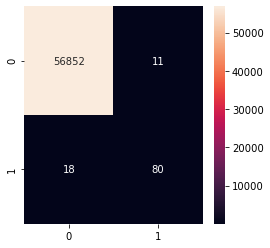

In [38]:
plot_confusion_mat(y_test, voting_pred)

In [41]:
# ROC curve for all the classifiers

plt.figure(figsize=(16, 12))
plt.plot(fpr_rf, tpr_rf, label = 'ROC curve', linewidth = 2)
plt.plot(fpr_xgb, tpr_xgb, label = 'ROC curve', linewidth = 2)
plt.plot(fpr_log, tpr_log, label = 'ROC curve', linewidth = 2)
plt.plot(fpr_voting, tpr_voting, label = 'ROC curve', linewidth = 2)
plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([0.0,0.001])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(['Rnd','Xgb', 'Log', 'Voting'], loc='upper left')
plt.savefig('6.roc.png')
plt.show();

NameError: name 'fpr_rf' is not defined

<Figure size 1152x864 with 0 Axes>